In [22]:
subj = "Subj3"
exp = "reproduction"

n_stages = [ 9, 8, 10 ][int(subj[-1:]) - 1]
scale = False

### Imports

In [23]:
%load_ext autoreload
%autoreload 2

import os

import SDA
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

import mne
import tqdm
import numpy
import pandas

pandas.set_option("display.precision", 2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data

In [24]:
data = mne.io.read_raw_fif(f"{subj}/src/data_rr_filt-raw.fif")
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif")
df_features = pandas.read_feather(f"{subj}/{exp}/features.feather")
features = df_features.to_numpy()
print('Features: ', features.shape)

Opening raw data file Subj3/src/data_rr_filt-raw.fif...
    Range : 3000 ... 654000 =      6.000 ...  1308.000 secs
Ready.
Reading d:\HSE\year-3\HSE\CourseProject\Subj3\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1180 matching events found
No baseline correction applied
0 projection items activated
Features:  (1180, 15)


In [25]:
if subj == "Subj2": # m8 (artifacts at the end)
    epochs = epochs[:-2]
    if exp != "reproduction": features = features[:-2]

### SDA

In [26]:
result, df_st_edges = SDA.SDA(scale = scale).apply(features)

Applying to 1180 samples with 15 features each
Running stage 1


  0%|          | 0/589 [00:00<?, ?it/s]

Running stage 2


  0%|          | 0/672 [00:00<?, ?it/s]

In [27]:
if exp != "reproduction":
    edges_true = numpy.loadtxt(f"{subj}/reproduction/internal/best_edges.txt").astype(numpy.int32)
    print(edges_true)

    metrics = [ ]
    for row in tqdm.tqdm(result['St_edges']):
        metrics.append(SDA.clustquality.cluster_metrics_ground(edges_true, row))
    result = pandas.concat([ result, pandas.DataFrame(metrics) ], axis = 1)

In [28]:
result.to_csv(f"{subj}/{exp}/result.csv")
df_st_edges.to_csv(f"{subj}/{exp}/df_st_edges.csv")

### Analysis

In [29]:
def analyze(result: pandas.DataFrame, key: str, folder: str):
    if not os.path.exists(f"{subj}/{exp}/{folder}"):
        os.makedirs(f"{subj}/{exp}/{folder}")

    results = SDA.analytics.best_results(result, key = key)
    results.to_csv(f"{subj}/{exp}/{folder}/results.csv")
    display(results)
    
    best_result = SDA.analytics.best_result(result, key = key, n_stages = n_stages)
    best_result_df = pandas.DataFrame([ best_result ])
    best_result_df.to_csv(f"{subj}/{exp}/{folder}/best_result.csv")
    display(best_result_df)
    
    best_edges = numpy.array(best_result['St_edges'])
    numpy.savetxt(f"{subj}/{exp}/{folder}/best_edges.txt", best_edges, fmt = "%d", newline = ' ')
    display(best_edges)

    edge_statistics = SDA.analytics.edge_statistics(features, best_edges)
    edge_statistics.to_csv(f"{subj}/{exp}/{folder}/edge_statistics.csv")
    display(edge_statistics)

    stage_timing = SDA.analytics.stage_timing(best_edges, epochs)
    stage_timing.to_csv(f"{subj}/{exp}/{folder}/stage_timing.csv")
    display(stage_timing)
    
    SDA.analytics.plot_features(df_features, best_edges).savefig(f"{subj}/{exp}/{folder}/features.svg")
    SDA.analytics.plot_eeg_stages(data, best_edges, epochs).savefig(f"{subj}/{exp}/{folder}/eeg_stages.svg")
    SDA.analytics.plot_stats(features, epochs, best_result, df_st_edges).savefig(f"{subj}/{exp}/{folder}/stats.svg")

#### Internal

,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold
0,0,40,20,3,Median,"[0, 192, 822, 1180]",81416.92,20.02,1.21e-01,170.67,2.45,0.19,194.83,2.02
1,60,50,10,4,Median,"[0, 196, 631, 897, 1180]",40557.43,16.68,8.71e-02,139.09,2.89,0.15,104.10,2.37
2,40,50,10,5,Median,"[0, 192, 510, 690, 938, 1180]",26231.19,14.68,3.28e-02,106.34,3.57,0.12,66.54,2.80
3,0,50,10,6,Median,"[0, 13, 192, 488, 690, 938, 1180]",21728.32,15.08,2.15e-02,86.49,3.44,0.11,54.85,2.71
4,0,50,15,7,Mean,"[0, 30, 208, 484, 699, 897, 1081, 1180]",16546.83,12.50,2.23e-03,74.15,5.13,0.10,42.81,3.85
5,60,35,20,8,Mode,"[0, 133, 261, 458, 622, 827, 938, 1037, 1180]",12198.54,12.50,-1.95e-02,74.76,3.93,0.09,33.80,3.22
6,40,45,20,9,Median,"[0, 133, 261, 495, 644, 745, 912, 1037, 1120, ...",11410.69,13.05,-1.35e-02,66.69,5.43,0.10,30.89,3.13
7,20,40,20,10,Mode,"[0, 133, 175, 261, 458, 685, 783, 938, 1037, 1...",9972.67,14.06,-3.04e-02,63.09,4.38,0.11,27.34,2.74
8,40,35,20,11,Mode,"[0, 83, 133, 261, 458, 622, 685, 783, 938, 103...",10133.90,14.04,-2.43e-02,60.01,4.70,0.11,28.21,2.84
9,40,40,15,12,Mode,"[0, 133, 175, 314, 458, 510, 685, 729, 783, 93...",8137.67,13.91,-4.02e-02,53.95,4.11,0.10,22.88,2.69


,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold
0,20,40,20,10,Mode,"[0, 133, 175, 261, 458, 685, 783, 938, 1037, 1...",9972.67,14.06,-0.03,63.09,4.38,0.11,27.34,2.74


array([   0,  133,  175,  261,  458,  685,  783,  938, 1037, 1126, 1180])

,Silh,Cal-Har,Dav-Bold,Ward,Centr
0,0.09,18.06,2.48,7758.39,15.59
1,0.16,24.06,2.09,7749.58,16.57
2,0.16,44.58,2.23,11497.32,13.86
3,0.06,29.04,3.58,9208.60,9.34
4,0.11,33.73,2.76,13288.89,13.93
5,0.04,13.51,4.06,6005.04,10.00
6,0.10,32.18,2.61,13367.90,14.88
7,0.12,28.48,2.49,11415.08,15.61
8,0.11,22.40,2.32,9463.25,16.78


,0,1,2,3,4,5,6,7,8,9
"Start-end time, sec","(8.5, 149.5)","(151.5, 198.5)","(200.5, 295.5)","(296.5, 516.5)","(517.5, 771.5)","(772.5, 877.5)","(878.5, 1046.5)","(1047.5, 1153.5)","(1154.5, 1247.5)","(1248.5, 1304.5)"
"Time length, sec",141.0,47.0,95.0,220.0,254.0,105.0,168.0,106.0,93.0,56.0
Number of epochs,133,42,86,197,227,98,155,99,89,54


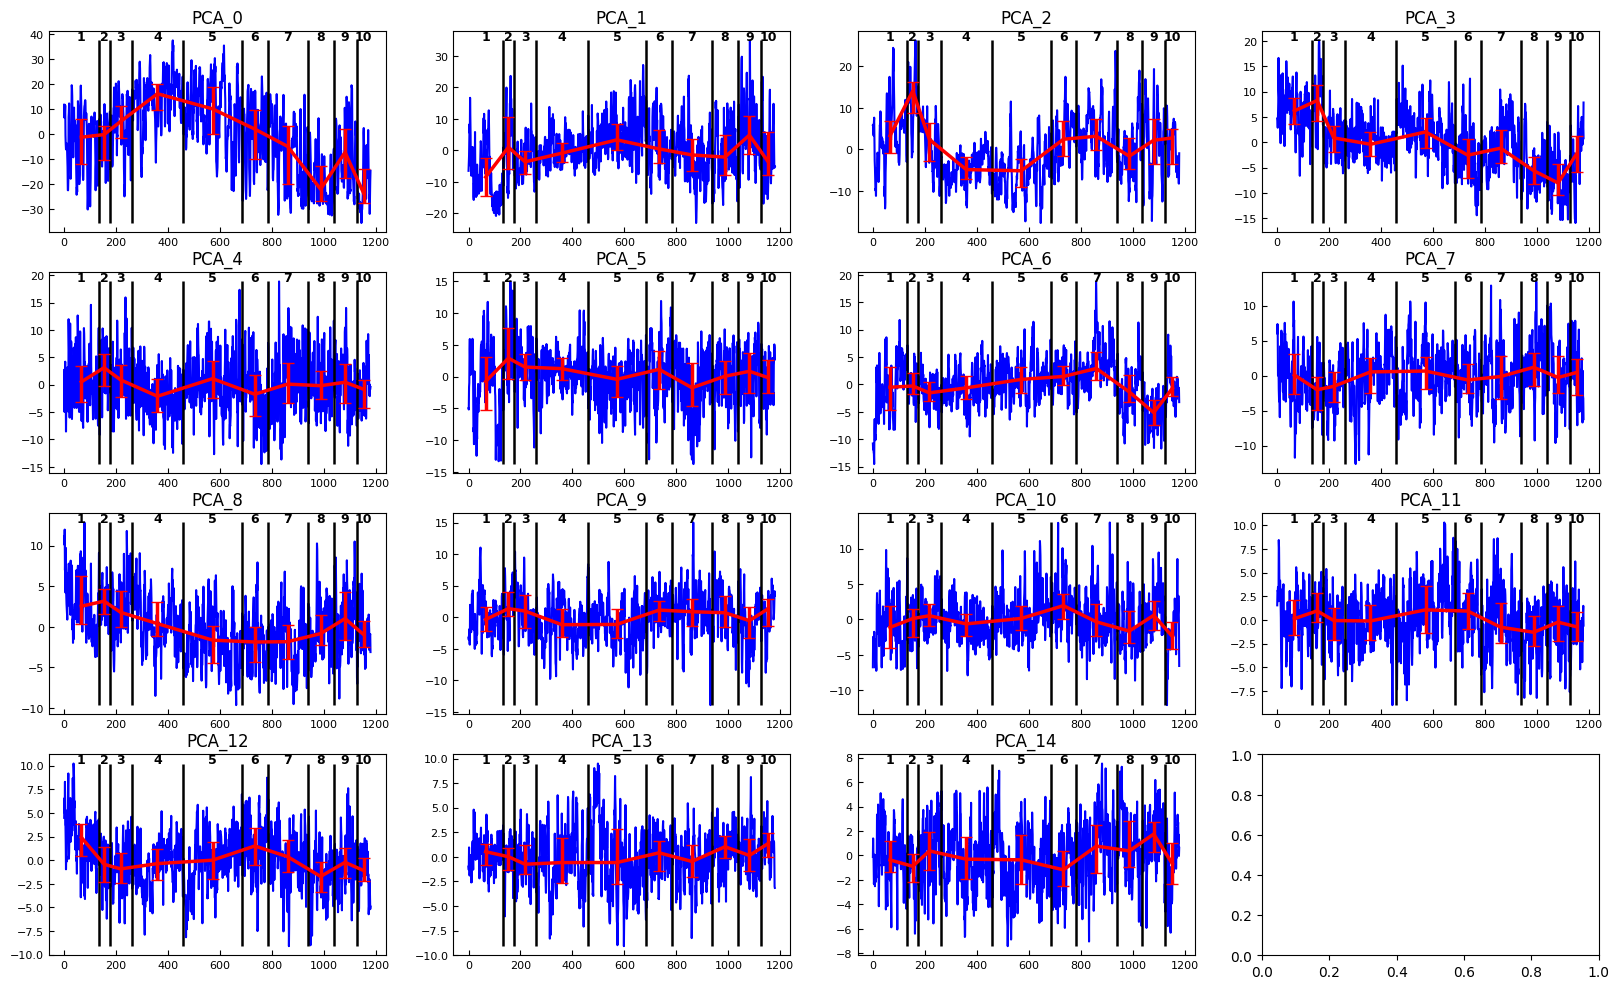

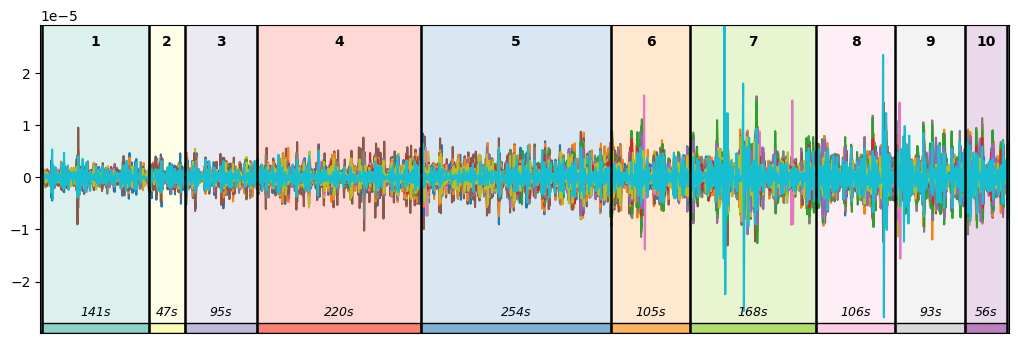

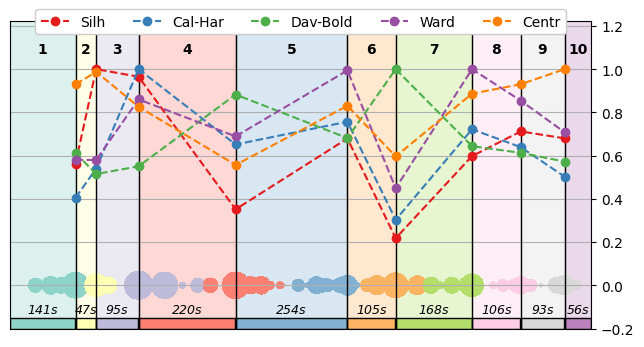

In [30]:
analyze(result, 'Avg-Silh', "internal")

![Alternative Text][1707850881559]

[1707850881559]: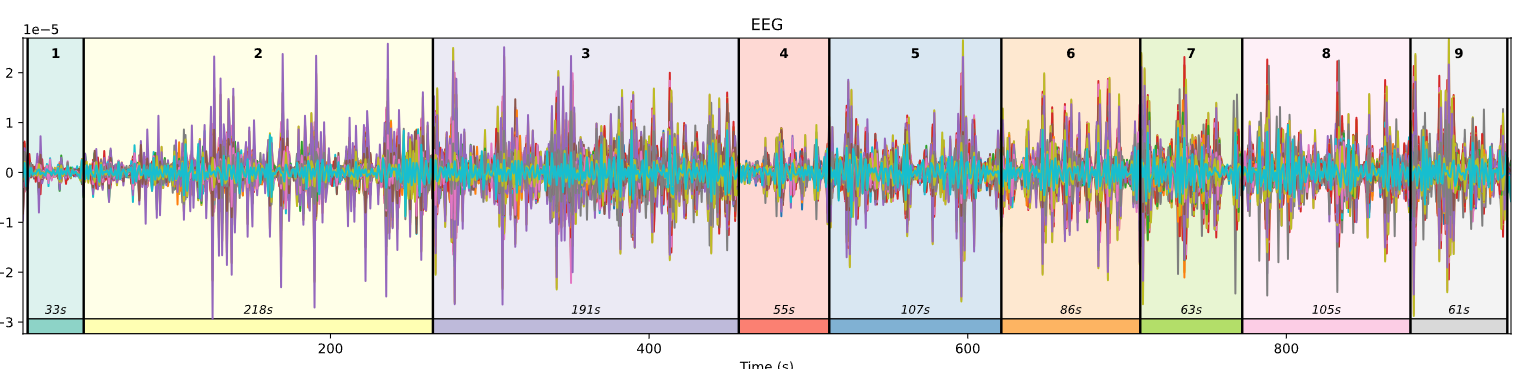

#### External

In [31]:
if exp != "reproduction":
    analyze(result, 'FMI', "external")

![Alternative Text][1707850881559]

[1707850881559]: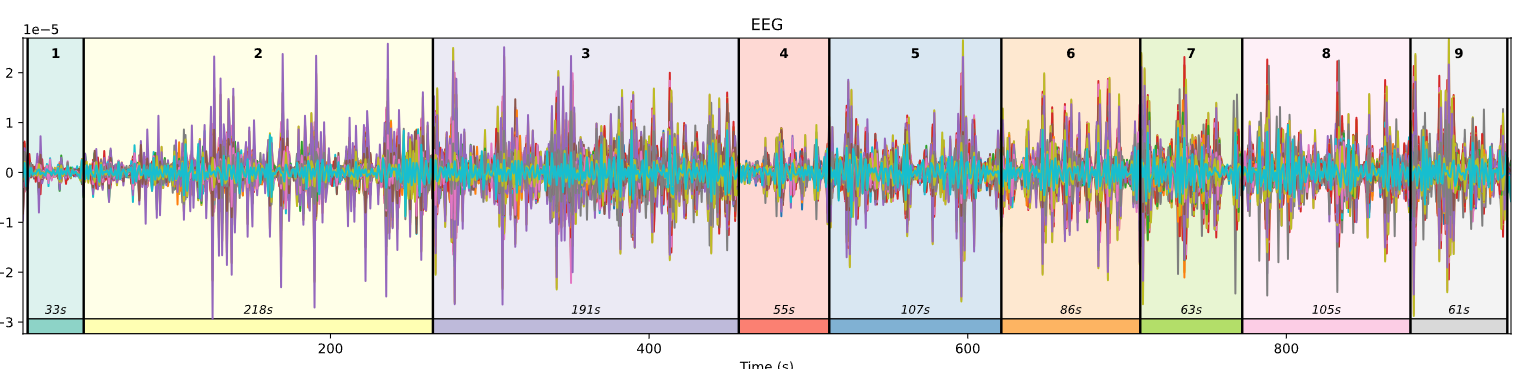